# sklearn Linear Regression

In this notebook, we will:

* Fit a linear regression model using scikit-learn’s closed-form least squares solver
* Evaluate model performance using standard regression metrics (RMSE, MAE, R²)
* Diagnose residual behavior using standard regression diagnostics
* Save benchmark results that will serve as the ground truth reference

In subsequent notebooks, we will:

* Implement linear regression from scratch using:

    * a closed-form solution
    * gradient descent optimization

* Verify that both approaches recover the scikit-learn solution
* Demonstrate convergence behavior of gradient descent toward the closed-form optimum

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

import scipy.stats as stats

# Data Loading and Initial Data Inspection

In [13]:
data = pd.read_csv("/Users/johnathonmin/vscode/ml-from-scratch/data/Student_Performance.csv")
data.info()
data.head(5)
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


# Exploratory Data Analysis

<Axes: >

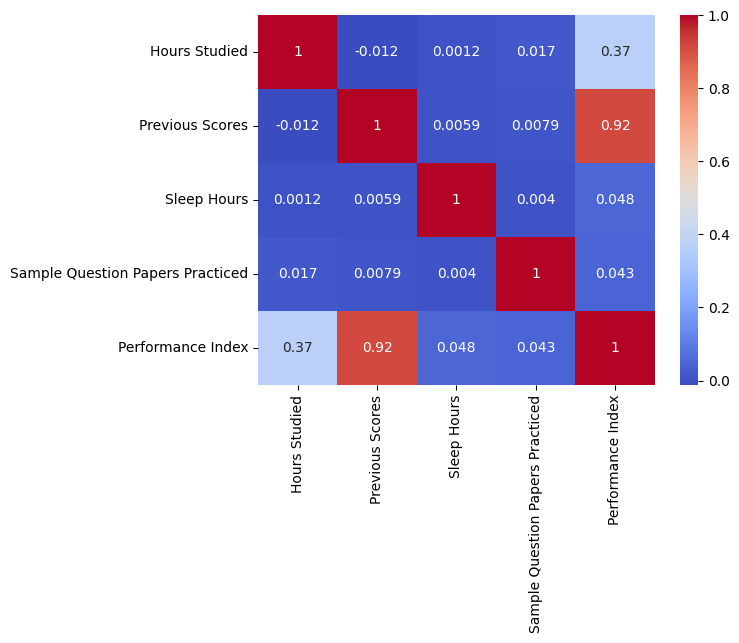

In [14]:
numerical_features = data.select_dtypes(include=[np.number])
corr_matrix = numerical_features.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")     

# Feature Engineering and Preprocessing

# Train/Test Split

In [15]:
# Define target and features
target = "Performance Index"
numeric_cols = data.select_dtypes(include=["int64", "float64"])
X = numeric_cols.drop(columns=[target])
y = numeric_cols[target]

print(X.shape)
print(y.shape)

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=123
)

(10000, 4)
(10000,)


# Model Training (sklearn)

In [16]:
sk_model = LinearRegression()
sk_model.fit(X_train, y_train)

y_pred = sk_model.predict(X_test)

/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


# Model Evaluation

In [17]:
# Standard metrics
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mean baseline (sanity check)
y_pred_mean = np.full_like(y_test, y_train.mean(), dtype=float)
rmse_mean = root_mean_squared_error(y_test, y_pred_mean)
mae_mean = mean_absolute_error(y_test, y_pred_mean)
r2_mean = r2_score(y_test, y_pred_mean)

print("Sklearn LinearRegression")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R^2: {r2:.4f}\n")

print("Mean baseline")
print(f"RMSE: {rmse_mean:.4f} | MAE: {mae_mean:.4f} | R^2: {r2_mean:.4f}")


Sklearn LinearRegression
RMSE: 2.1416 | MAE: 1.7086 | R^2: 0.9874

Mean baseline
RMSE: 19.0998 | MAE: 16.1217 | R^2: -0.0003


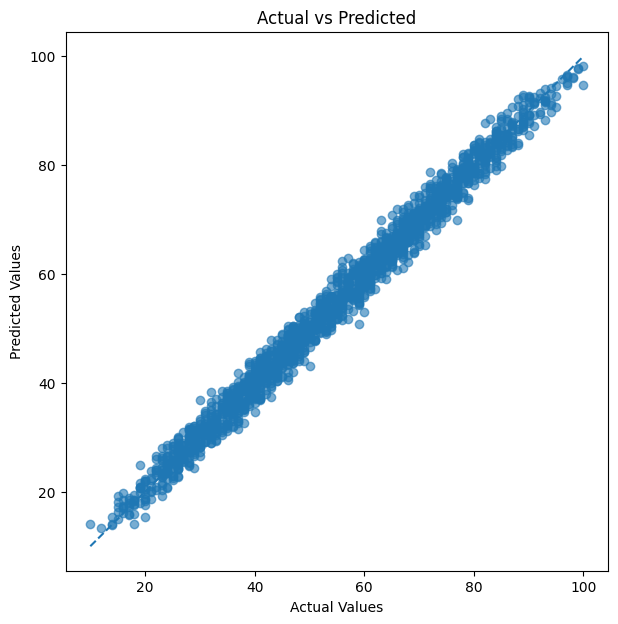

In [18]:
# Actual vs. Fitted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

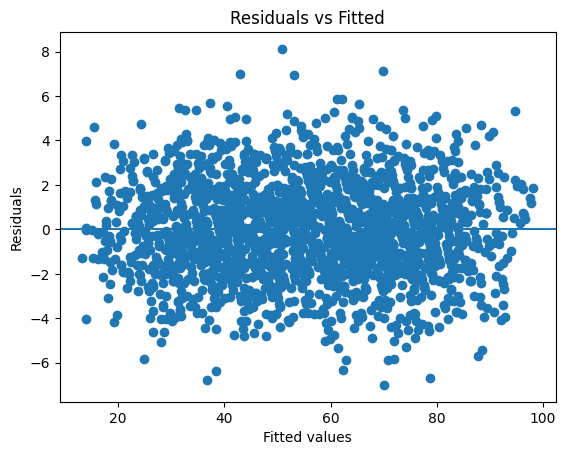

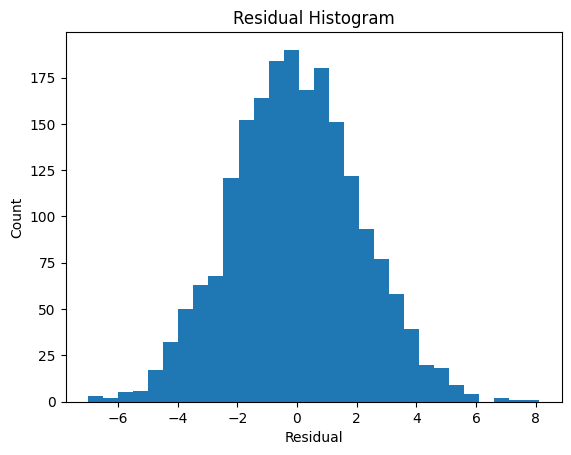

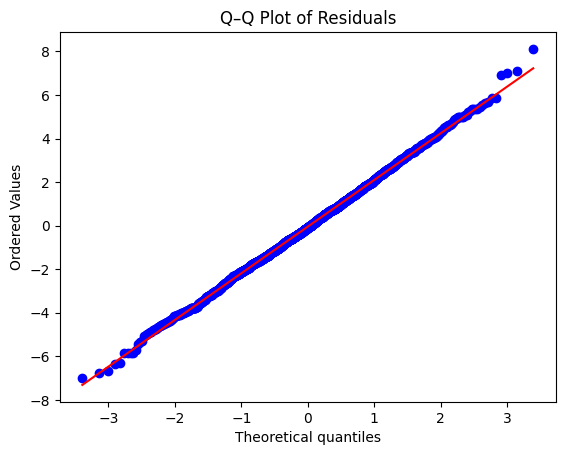

In [19]:
# Residual diagnostics
resid = y_test - y_pred

# Residuals vs fitted
plt.figure()
plt.scatter(y_pred, resid)
plt.axhline(0)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Residual histogram
plt.figure()
plt.hist(resid, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Histogram")
plt.show()

# Q–Q plot
plt.figure()
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()


In [20]:
# Save sklearn benchmarks
benchmark_df = pd.DataFrame({
    "y_test": y_test,
    "y_pred_sklearn": y_pred,
    "residual": resid
})

benchmark_df.to_csv("/Users/johnathonmin/vscode/ml-from-scratch/data/linear_reg_sklearn_benchmark.csv")